In [3]:
# !pip install wordcloud

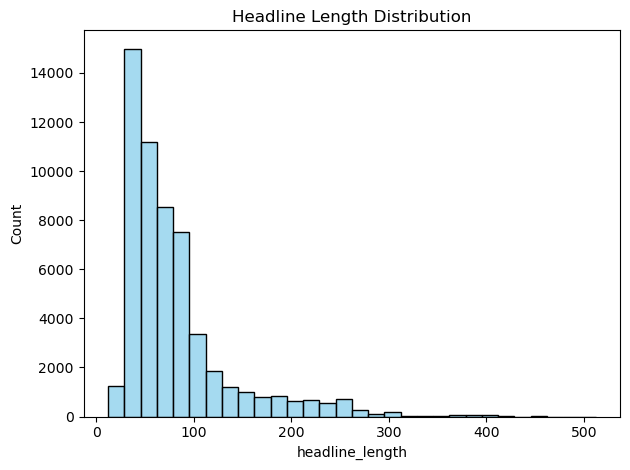

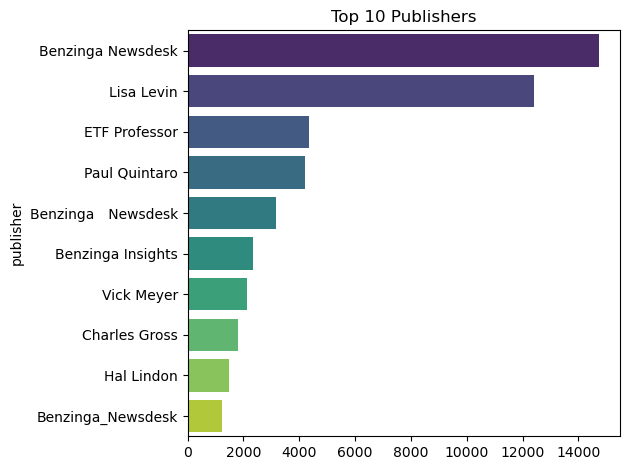

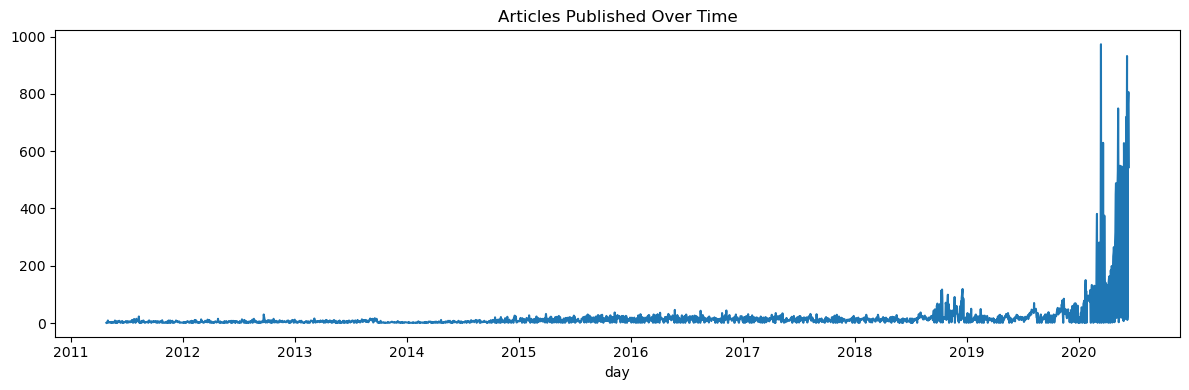

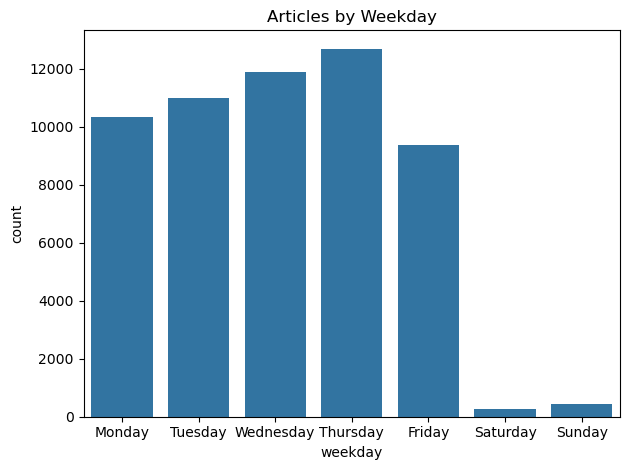

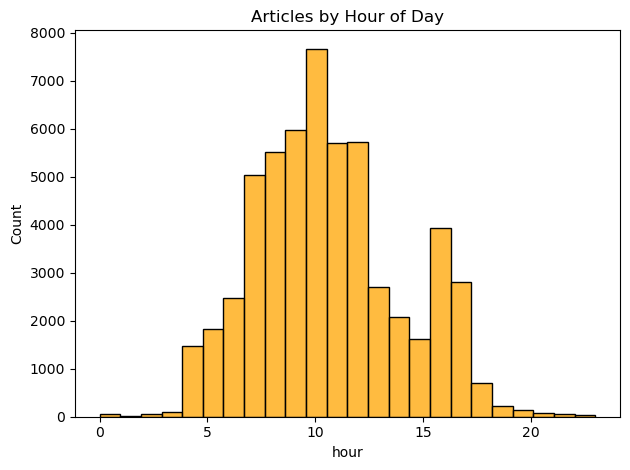


Top Keywords: ['52', 'companies', 'eps', 'estimate', 'higher', 'hit', 'lows', 'maintains', 'market', 'new', 'price', 'q1', 'sales', 'session', 'shares', 'stocks', 'target', 'trading', 'week', 'yesterday']


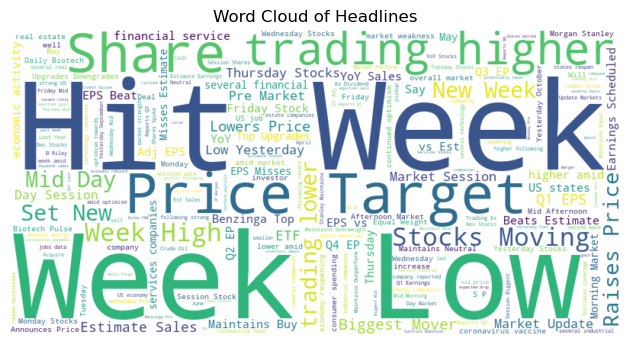


Top publisher domains:
 domain
benzinga.com    1196
gmail.com          3
Name: count, dtype: int64

 Sentiment scores added.

 All EDA plots saved in 'output/eda'


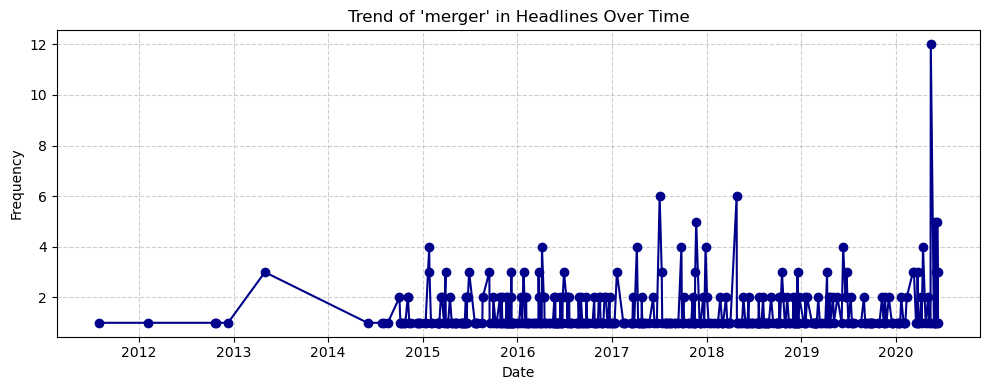

No articles found for publisher: Reuters


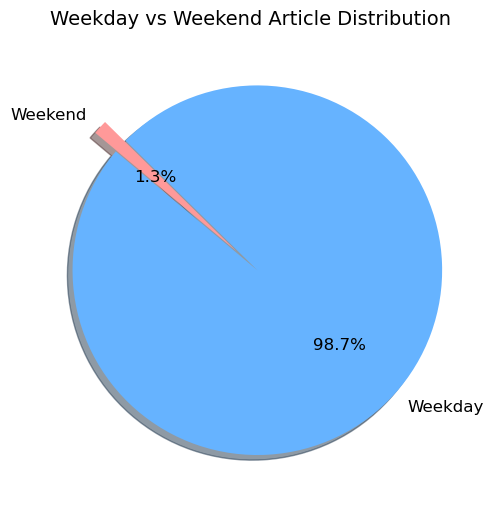

In [23]:
"""
NewsAnalyzer: A class to perform EDA on financial news headlines
Task 1 - 10 Academy AIM Week 1 Challenge
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from typing import Optional

import warnings
warnings.filterwarnings('ignore')

class NewsAnalyzer:
    def __init__(self, csv_path: str, output_dir: str = "output/eda", show_plots: bool = False):
        self.csv_path = csv_path
        self.output_dir = output_dir
        self.show_plots = show_plots
        os.makedirs(self.output_dir, exist_ok=True)
        self.df: Optional[pd.DataFrame] = None

    def load_and_prepare(self) -> None:
        """Load and preprocess the dataset."""
        self.df = pd.read_csv(self.csv_path)
        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')
        self.df.dropna(subset=['headline', 'date'], inplace=True)
        self.df['headline'] = self.df['headline'].astype(str).str.strip()
        self.df['publisher'] = self.df['publisher'].astype(str).str.strip()
        self.df['headline_length'] = self.df['headline'].apply(len)
        self.df['day'] = self.df['date'].dt.date
        self.df['weekday'] = self.df['date'].dt.day_name()
        self.df['hour'] = self.df['date'].dt.hour
        self.df['domain'] = self.df['publisher'].str.extract(r'@([\w\.-]+)')

    def generate_descriptive_stats(self) -> None:
        """Plot headline length distribution and publisher frequency."""
        sns.histplot(self.df['headline_length'], bins=30, color='skyblue')
        plt.title("Headline Length Distribution")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/headline_length_dist.png")
        if self.show_plots:
            plt.show()
        plt.close()

        top_publishers = self.df['publisher'].value_counts().head(10)
        sns.barplot(y=top_publishers.index, x=top_publishers.values, palette="viridis")
        plt.title("Top 10 Publishers")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/top_publishers.png")
        if self.show_plots:
            plt.show()
        plt.close()

    def analyze_publication_trends(self) -> None:
        """Visualize articles over time, by weekday, and by hour."""
        self.df.groupby('day').size().plot(figsize=(12, 4))
        plt.title("Articles Published Over Time")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/articles_over_time.png")
        if self.show_plots:
            plt.show()
        plt.close()

        sns.countplot(x='weekday', data=self.df,
                      order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        plt.title("Articles by Weekday")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/articles_by_weekday.png")
        if self.show_plots:
            plt.show()
        plt.close()

        sns.histplot(self.df['hour'].dropna(), bins=24, color='orange')
        plt.title("Articles by Hour of Day")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/articles_by_hour.png")
        if self.show_plots:
            plt.show()
        plt.close()

    def extract_topics(self) -> None:
        """Extract top keywords and generate word cloud."""
        vectorizer = CountVectorizer(max_features=20, stop_words='english')
        X = vectorizer.fit_transform(self.df['headline'])
        keywords = vectorizer.get_feature_names_out()
        print("\nTop Keywords:", list(keywords))

        text = " ".join(self.df['headline'].tolist())
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud of Headlines")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/wordcloud.png")
        if self.show_plots:
            plt.show()
        plt.close()

    def analyze_domains(self) -> None:
        """Check for email-like publisher domains."""
        domain_counts = self.df['domain'].value_counts().dropna().head(5)
        if not domain_counts.empty:
            print("\nTop publisher domains:\n", domain_counts)
        else:
            print("\nNo valid publisher domains found.")

    def add_sentiment_scores(self) -> None:
        """Add sentiment polarity to each headline."""
        self.df['sentiment'] = self.df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
        print("\n Sentiment scores added.")

    def top_keywords_by_publisher(self, publisher_name: str, top_n: int = 10) -> None:
        """Print top N keywords used by a given publisher."""
        subset = self.df[self.df['publisher'].str.contains(publisher_name, case=False)]
        if subset.empty:
            print(f"No articles found for publisher: {publisher_name}")
            return

        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(subset['headline'])
        word_counts = X.sum(axis=0).A1
        vocab = vectorizer.get_feature_names_out()
        top_indices = word_counts.argsort()[::-1][:top_n]

        print(f"\n Top {top_n} keywords for {publisher_name}:")
        for idx in top_indices:
            print(f"{vocab[idx]} ({word_counts[idx]})")

        top_keywords = [(vocab[idx], word_counts[idx]) for idx in top_indices]
        words, counts = zip(*top_keywords)
        plt.figure(figsize=(8, 4))
        sns.barplot(x=list(counts), y=list(words), palette='cubehelix')
        plt.title(f"Top {top_n} Keywords for {publisher_name}")
        plt.xlabel("Frequency")
        plt.tight_layout()
        if self.show_plots:
            plt.show()
        plt.close()


    def plot_keyword_trend(self, keyword: str) -> None:
        """Plot frequency of keyword in headlines over time (with style)."""
        self.df['contains_keyword'] = self.df['headline'].str.contains(keyword, case=False, na=False)
        trend = self.df[self.df['contains_keyword']].groupby('day').size()
    
        if trend.empty:
            print(f"No headlines contain the keyword: '{keyword}'")
            return
    
        plt.figure(figsize=(10, 4))
        plt.plot(trend.index, trend.values, marker='o', linestyle='-', color='darkblue')
        plt.title(f"Trend of '{keyword}' in Headlines Over Time")
        plt.xlabel("Date")
        plt.ylabel("Frequency")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        if self.show_plots:
            plt.show()
        plt.close()


    def compare_weekday_weekend(self) -> None:
        """pie chart for weekday vs weekend publishing."""
        self.df['is_weekend'] = self.df['weekday'].isin(['Saturday', 'Sunday'])
        counts = self.df['is_weekend'].value_counts()
        labels = ['Weekday', 'Weekend']
        explode = [0.05, 0.1]
    
        plt.figure(figsize=(6, 6))
        plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'],
                startangle=140, explode=explode, shadow=True, textprops={'fontsize': 12})
        plt.title("Weekday vs Weekend Article Distribution", fontsize=14)
        if self.show_plots:
            plt.show()
        plt.close()


    def run_all(self) -> None:
        """Run full EDA pipeline."""
        self.load_and_prepare()
        self.generate_descriptive_stats()
        self.analyze_publication_trends()
        self.extract_topics()
        self.analyze_domains()
        self.add_sentiment_scores()
        print(f"\n All EDA plots saved in '{self.output_dir}'")

    def plot_sentiment_distribution(self) -> None:
        """Plot sentiment polarity distribution and trend over time."""
        if 'sentiment' not in self.df.columns:
            self.add_sentiment_scores()
    
        # Distribution
        plt.figure(figsize=(8, 4))
        sns.histplot(self.df['sentiment'], bins=30, kde=True, color='purple')
        plt.title("Sentiment Polarity Distribution")
        plt.xlabel("Sentiment Score")
        plt.tight_layout()
        if self.show_plots:
            plt.show()
        plt.close()
    
        # Daily average trend
        sentiment_trend = self.df.groupby('day')['sentiment'].mean()
        plt.figure(figsize=(10, 4))
        plt.plot(sentiment_trend.index, sentiment_trend.values, color='teal', marker='o')
        plt.title("Daily Average Sentiment Trend")
        plt.xlabel("Date")
        plt.ylabel("Average Sentiment")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        if self.show_plots:
            plt.show()
        plt.close()
    
    
if __name__ == "__main__":
    analyzer = NewsAnalyzer(csv_path="../data/raw_analyst_ratings.csv", show_plots=True)
    analyzer.run_all()
    analyzer.plot_keyword_trend("merger")
    analyzer.top_keywords_by_publisher("Reuters")
    analyzer.compare_weekday_weekend()

In [16]:
# !pip install textblob